# 신용카드 채무 불이행 고객 예측 Project 1

In [2]:
! pip install klib

## [데이터 불러오기]

In [1]:
import pandas as pd

df = pd.read_csv('credit_card_pay.xlsx - Data.csv')
df.head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0


Displaying absolute correlations above the threshold (0.3). Specify a positive "threshold" to limit the results further.


<AxesSubplot: title={'center': 'Feature-correlation (pearson)'}>

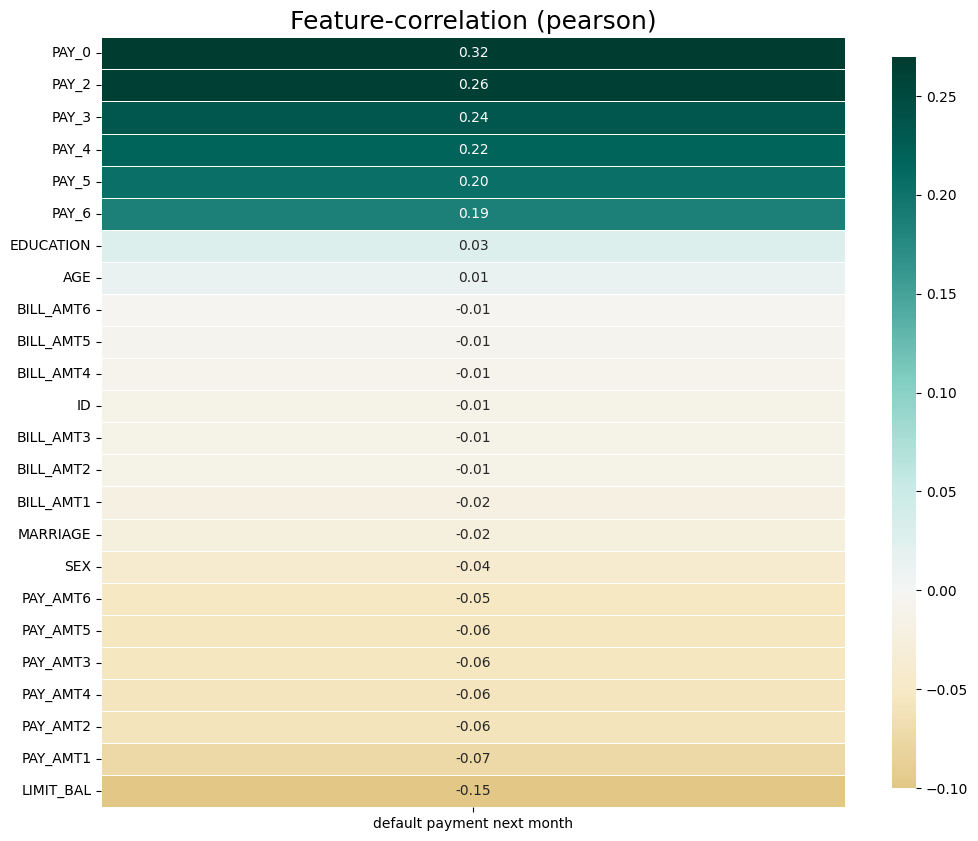

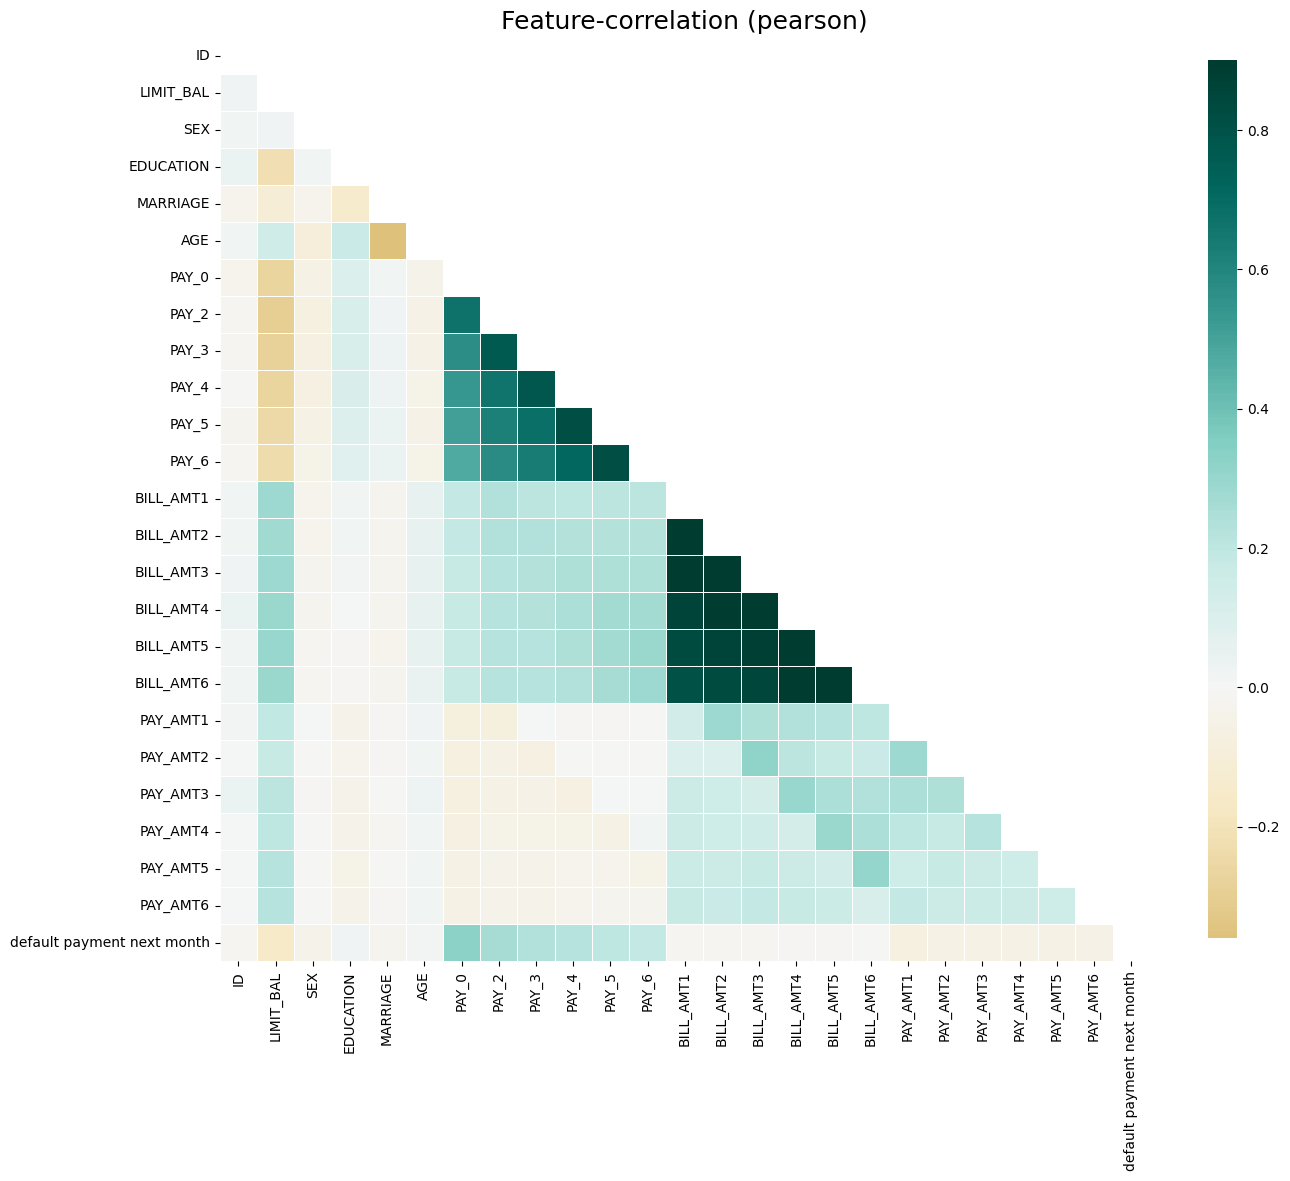

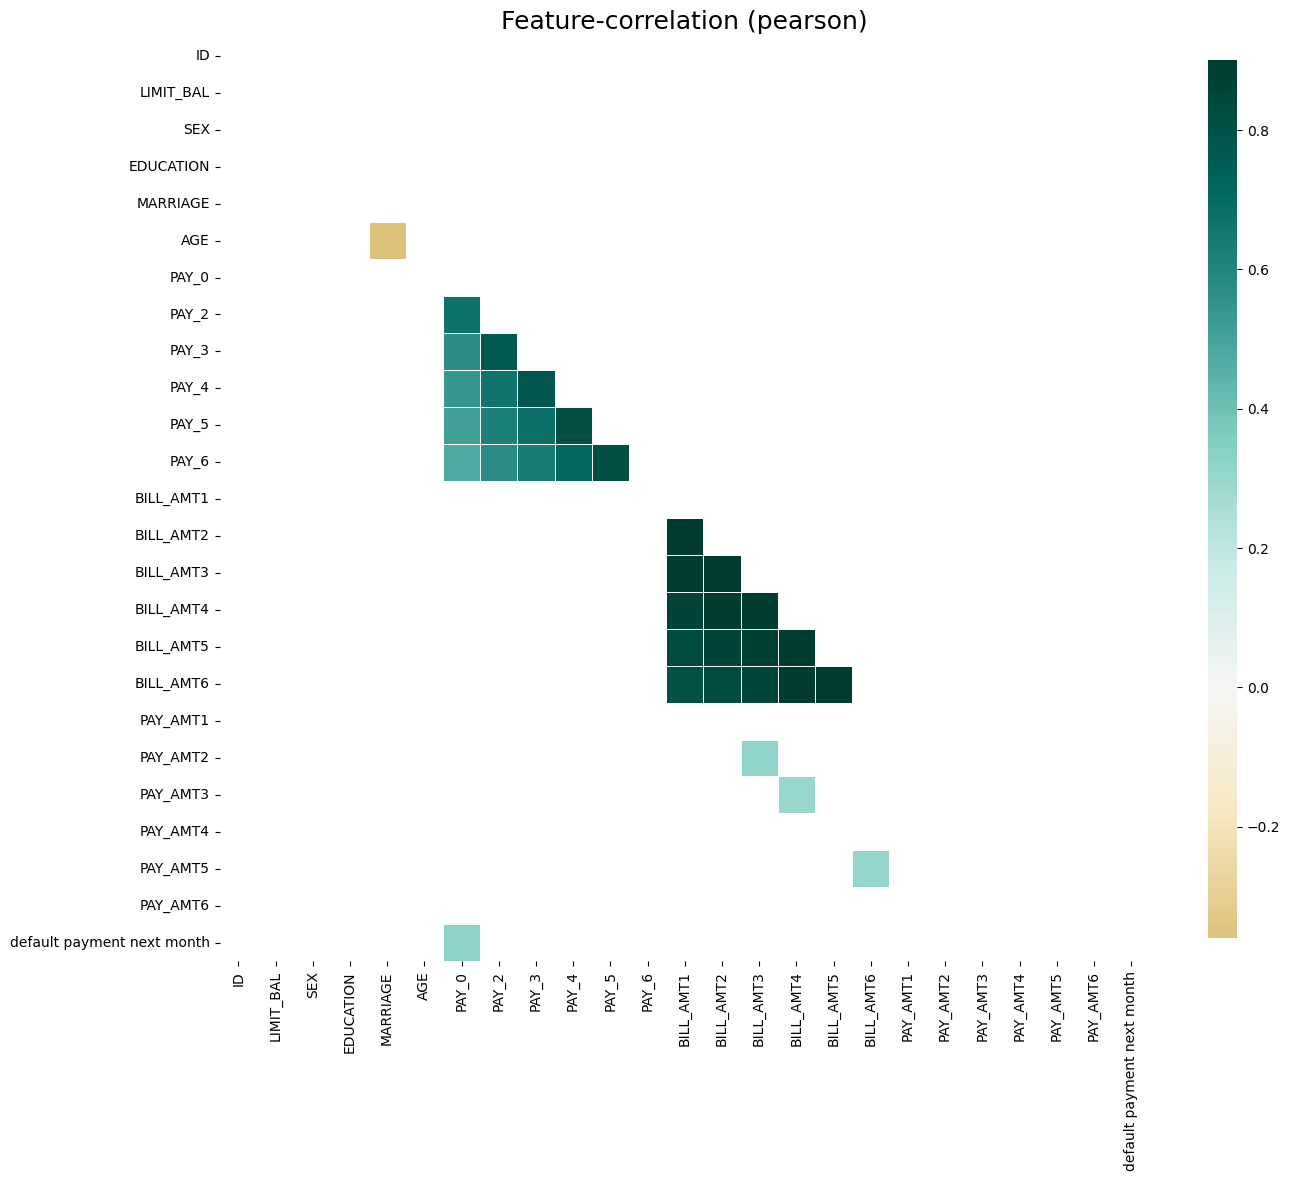

In [4]:
import klib
klib.corr_plot(df, target='default payment next month')
klib.corr_plot(df, annot=False, figsize=(15,12))
klib.corr_plot(df, split='high', annot=False, figsize=(15,12))

In [15]:
df.iloc[6]

ID                                 7
LIMIT_BAL                     500000
SEX                                1
EDUCATION                          1
MARRIAGE                           2
AGE                               29
PAY_0                              0
PAY_2                              0
PAY_3                              0
PAY_4                              0
PAY_5                              0
PAY_6                              0
BILL_AMT1                     367965
BILL_AMT2                     412023
BILL_AMT3                     445007
BILL_AMT4                     542653
BILL_AMT5                     483003
BILL_AMT6                     473944
PAY_AMT1                       55000
PAY_AMT2                       40000
PAY_AMT3                       38000
PAY_AMT4                       20239
PAY_AMT5                       13750
PAY_AMT6                       13770
default payment next month         0
Name: 6, dtype: int64

> **데이터 살펴보기**

* 고객 ID별 카드 청구 data
* 데이터 명세 ⬇

|ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|
|:---:|:---:|:---:|:---:|:---:|:---:|
|고객 아이디|신용한도|성별(1-남성, 2-여성)|교육수준(1-대학원, 2-대학교, 3-고등학교, 4-기타, 5-모름, 6-모름)|결혼(1-기혼, 2-독신, 3-기타)|나이||
|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|
|05년9월 상환상태(-2-무소비, -1-정액 결제, 0-리볼빙크레딧, 1-한달 지연, ..., 9-9개월 지불지연)|05년8월 상환상태|05년7월 상환상태|05년6월 상환상태|05년5월 상환상태|05년4월 상환상태|
|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|
|05년9월 청구서 금액|05년8월 청구서 금액|05년7월 청구서 금액|05년6월 청구서 금액|05년5월 청구서 금액|05년4월 청구서 금액|
|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|
|05년9월 지불금액|05년8월 지불금액|05년7월 지불금액|05년6월 지불금액|05년5월 지불금액|05년4월 지불금액|
|default payment next month|
|채무 불이행 여부|

## [문제해결 process]

### 문제 : 신용카드 대금 채무 불이행으로 인한 손실

### 해결방안 : 
 1. 고객 프로필 정보 확인 및 파생변수 생성
 2. 고객 프로필 정보 (신용한도 대비 총 청구금액, 결제 지연기간 등), 각 feature에 따른 채무 불이행률 탐색
 3. ML알고리즘 활용 (XGBoost, LightGBM)활용 채무 불이행 고객 예측

### 가설
1. 신용한도 내에 청구되는 금액이 많은 고객일수록 채무 불이행할 확률이 높을까?
2. 청구금액의 증감율이 크다. -> 급격한 소비는 default할 가능성이 높다?
3. 결제지연 기간이 길어지면 길어질 수록 연체할 확률이 높을 수 있다는 가정
4. 고객의 연령이 낮을 수록 채무를 불이행할 확률이 높다는 가정

## [데이터 전처리 및 파생변수 생성 및 검증]
 - Data의 각 column확인 및 Data type 확인
 - Null값 확인
 - Outlier 확인

In [ ]:
# pay_0의 -2, -1, 0 (무소비, 정액결제, 리볼빙으로 예상)을 모두 0값으로 치환
# bill_amt -> id별로 청구금액이 0 카운트해서 6인 고객은 drop
# 신용한도 대비 청구금액의 평균을 계산하여 채무불이행 여부와 상관관계 확인
# 지난 달 대비 이번 달 청구금액 증감율 -> NaN값 처리  (청구금액의 급격한 변화 -> default를 할 가능성이 높다?)

In [22]:
# Data type 확인

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [23]:
# target data인 채무 불이행 여부 확인 

df['default payment next month'].value_counts()

0    23364
1     6636
Name: default payment next month, dtype: int64

In [24]:
# Data의 사분위수 및 요약 확인

df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [26]:
# 신용한도 

df['LIMIT_BAL'].unique()

array([  20000,  120000,   90000,   50000,  500000,  100000,  140000,
        200000,  260000,  630000,   70000,  250000,  320000,  360000,
        180000,  130000,  450000,   60000,  230000,  160000,  280000,
         10000,   40000,  210000,  150000,  380000,  310000,  400000,
         80000,  290000,  340000,  300000,   30000,  240000,  470000,
        480000,  350000,  330000,  110000,  420000,  170000,  370000,
        270000,  220000,  190000,  510000,  460000,  440000,  410000,
        490000,  390000,  580000,  600000,  620000,  610000,  700000,
        670000,  680000,  430000,  550000,  540000, 1000000,  530000,
        710000,  560000,  520000,  750000,  640000,   16000,  570000,
        590000,  660000,  720000,  327680,  740000,  800000,  760000,
        690000,  650000,  780000,  730000], dtype=int64)

In [27]:
df['LIMIT_BAL'].min()

10000

In [28]:
df['LIMIT_BAL'].max()

1000000

In [29]:
# Data의 NaN값 확인

df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [2]:
# pay_0의 -2, -1, 0 (무소비, 정액결제, 리볼빙으로 예상)을 모두 0값으로 치환 -> 모델의 학습과 결과적으로 -2, -1, 0 모두 채무를 이행하려는 의지가 있다고 보고 모두 0으로 치환

import numpy as np
# -2, -1, 0 -> 0
df['PAY_0'] = np.where((df['PAY_0']<=0), 0, df['PAY_0'])
df['PAY_2'] = np.where((df['PAY_2']<=0), 0, df['PAY_2'])
df['PAY_3'] = np.where((df['PAY_3']<=0), 0, df['PAY_3'])
df['PAY_4'] = np.where((df['PAY_4']<=0), 0, df['PAY_4'])
df['PAY_5'] = np.where((df['PAY_5']<=0), 0, df['PAY_5'])
df['PAY_6'] = np.where((df['PAY_6']<=0), 0, df['PAY_6'])
# (PAY_X 평균)/(신용한도/10000): 클수록 디폴트 가능성 높음. (default와 상관관계 0.100799)
# classification이므로 추후 변수제거 안해도 됨.
# df['delay/Limit_bal']=((df['PAY_0']+df['PAY_2']+df['PAY_3']+df['PAY_4']+df['PAY_5']+df['PAY_6'])/6)/(df['LIMIT_BAL']/10000)

In [4]:
# 결제 지연 기간 총합 (-2 : 무소비 고객)

df['PAY_0'] + df['PAY_2'] + df['PAY_3'] + df['PAY_4'] + df['PAY_5'] + df['PAY_6']

0       -2
1        3
2        0
3        0
4       -2
        ..
29995    0
29996   -4
29997    8
29998   -1
29999    0
Length: 30000, dtype: int64

In [17]:
# 신용한도 대비 청구금액의 총합을 나눈 컬럼 추가 -> 자신의 신용 한도에 비해 어느정도의 금액을 쓰는지 보기 위함. 이 수치가 채무를 불이행 확률이 높다고 판단.

df['LIMIT_USE_AVG'] = (df['BILL_AMT1'] + df['BILL_AMT2'] + df['BILL_AMT3'] + df['BILL_AMT4'] + df['BILL_AMT5'] + df['BILL_AMT6']) / df['LIMIT_BAL']
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,LIMIT_USE_AVG
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,689,0,0,0,0,1,0.385200
1,2,120000,2,2,2,26,-1,2,0,0,...,3455,3261,0,1000,1000,1000,0,2000,1,0.142308
2,3,90000,2,2,2,34,0,0,0,0,...,14948,15549,1518,1500,1000,1000,1000,5000,0,1.129478
3,4,50000,2,2,1,37,0,0,0,0,...,28959,29547,2000,2019,1200,1100,1069,1000,0,4.626680
4,5,50000,1,2,1,57,-1,0,-1,0,...,19146,19131,2000,36681,10000,9000,689,679,0,2.186780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,31237,15980,8500,20000,5003,3047,5000,1000,0,3.297041
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,5190,0,1837,3526,8998,129,0,0,0,0.141213
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20582,19357,0,0,22000,4200,2000,3100,1,2.349867
29998,29999,80000,1,3,1,41,1,-1,0,0,...,11855,48944,85900,3409,1178,1926,52964,1804,1,3.332638


In [73]:
df['PAY_6'].unique()

array([0, 2, 3, 6, 4, 7, 8, 5], dtype=int64)

In [ ]:
# 일반적인 Tree기반 알고리즘은 균형 트리 분할(Level-wise)방법을 사용하는데 이에 해당되는 대표적인 앙상블 모델이 XGBoost모델.
# XGBoost모델은 최대한 균형이 잡힌 tree를 유지하면서 분석하기 때문에 트리의 깊이가 최소화가 될 수 있지만 그 만큼 시간이 오래 걸리는 단점을 가지고 있다.
# LightGBM은 리프 중심 트리 분할(Leaf-wise)의 대표적인 모델. 이 모델은 일반적인 균형 트리 분할과는 다르게 균형을 맞추지 않고 최대 손실 값(max data loss)을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊고, 비대칭적인 트리를 생성한다. 이렇게 생성된 비대칭적인 트리는 균형트리 분할보다 손실을 줄일 수 있는 장점이 있음.

## 파생변수 컬럼 추가

In [34]:
# 신용 한도 대비 청구금액의 평균 비율 -> 신용한도에 근접하게 사용하는 사람일수록 지불해야하는 금액도 많기에 그만큼 채무를 불이행할 확률이 높다고 예상
df['LIMIT_USE_AVG'] = (df['BILL_AMT1'] + df['BILL_AMT2'] + df['BILL_AMT3'] + df['BILL_AMT4'] + df['BILL_AMT5'] + df['BILL_AMT6']) / df['LIMIT_BAL']

In [34]:
# 연체이력 : 결제 지연 기간(PAY_0 ~ PAY_6)의 총합 평균을 신용한도로 나눔 -> 결제 지연이 길어질수록 채무 불이행할 확률 높아진다고 판단.
df['delay/Limit_bal']=((df['PAY_0']+df['PAY_2']+df['PAY_3']+df['PAY_4']+df['PAY_5']+df['PAY_6'])/6)/(df['LIMIT_BAL']/10000)

In [34]:
# 월별 청구금액 컬럼 추출 -> 청구금액이 급격하게 증가한 고객은 채무불이행할 가능성이 높다고 판단
bill_amt_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
bill_amt = df[bill_amt_cols]

# 월별 청구금액 증감률 계산 
bill_change = bill_amt.pct_change(axis=1)
bill_change = bill_change.replace([np.inf, -np.inf], np.nan).fillna(0)

# 청구금액 증감률 평균 계산
bill_change['bill_change_mean'] = bill_change.mean(axis=1)

# 데이터프레임에 추가
df = pd.concat([df, bill_change['bill_change_mean']], axis=1)

## 파생변수 시각화

### - 일반적인 Tree기반 알고리즘은 균형 트리 분할(Level-wise)방법을 사용하는데 이에 해당되는 대표적인 앙상블 모델이 XGBoost모델.
### - XGBoost모델은 최대한 균형이 잡힌 tree를 유지하면서 분석하기 때문에 트리의 깊이가 최소화가 될 수 있지만 그 만큼 시간이 오래 걸리는 단점을 가지고 있다.
### - LightGBM은 리프 중심 트리 분할(Leaf-wise)의 대표적인 모델. 이 모델은 일반적인 균형 트리 분할과는 다르게 균형을 맞추지 않고 최대 손실 값(max data loss)을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊고, 비대칭적인 트리를 생성한다. 이렇게 생성된 비대칭적인 트리는 균형트리 분할보다 손실을 줄일 수 있는 장점이 있음.

## [Model 생성 및 학습]

In [7]:
# LightGBM

!pip install lightgbm

     ---------------------------------------- 1.0/1.0 MB 10.9 MB/s eta 0:00:00


In [4]:
# LightGBM 모델 생성

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# 데이터 불러오기
df = pd.read_csv('credit_card_pay.xlsx - Data.csv')

# 파생변수 추가
df['LIMIT_USE_AVG'] = (df['BILL_AMT1'] + df['BILL_AMT2'] + df['BILL_AMT3'] + df['BILL_AMT4'] + df['BILL_AMT5'] + df['BILL_AMT6']) / df['LIMIT_BAL']    # 신용한도에 따른 총 청구금액 비율
df['delay/Limit_bal']=((df['PAY_0']+df['PAY_2']+df['PAY_3']+df['PAY_4']+df['PAY_5']+df['PAY_6'])/6)/(df['LIMIT_BAL']/10000)                            # 신용한도에 따른 결제지연 기간의 총합
df['delay']=(df['PAY_0']+df['PAY_2']+df['PAY_3']+df['PAY_4']+df['PAY_5']+df['PAY_6'])/6                                                                # 결제 지연기간의 평균

df['LIMIT_BAL_GP'] = np.where (df['LIMIT_BAL'] <= 100000, 1,                                                                                           # 신용등급 4분위수로 그룹화
                           np.where(df['LIMIT_BAL'] <= 300000, 2,
                           np.where(df['LIMIT_BAL'] <= 500000, 3, 4)))
df.LIMIT_BAL_GP.value_counts(), sorted(df.LIMIT_BAL_GP.unique()), len(df.LIMIT_BAL_GP.unique())

df['EDUCATION_re'] = np.where ((0 < df['EDUCATION']) & (df['EDUCATION'] <= 3), df['EDUCATION'], 4)                                                     # 학력

bill_amt_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']                                                         # 월별 청구금액 증감률
bill_amt = df[bill_amt_cols]
bill_change = bill_amt.pct_change(axis=1)
bill_change = bill_change.replace([np.inf, -np.inf], np.nan).fillna(0)
bill_change['bill_change_mean'] = bill_change.mean(axis=1)
df = pd.concat([df, bill_change['bill_change_mean']], axis=1)


# 학습/검증 데이터 분리
X = df.drop(['ID', 'default payment next month', 'SEX', 'MARRIAGE'], axis=1)                                                                            # 성별, 결혼여부 컬럼은 drop
y = df['default payment next month']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [7]:
# LightGBM 모델 학습
params = {
    'learning_rate': 0.01,
    'max_depth': 5,
    'n_estimators': 100,
    'objective': 'binary',
    'boosting': 'gbdt',
    'metric': 'binary_logloss'
}

train_ds = lgb.Dataset(X_train, label=y_train)
val_ds = lgb.Dataset(X_val, label=y_val)
model = lgb.train(params, train_ds, 1000, val_ds, verbose_eval=10, early_stopping_rounds=100)

# feature importance 출력
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importance()})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
print(feature_importance)

C:\Users\GM220808\.venv\Practice1\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\GM220808\.venv\Practice1\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\GM220808\.venv\Practice1\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4073
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 27
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221208 -> initscore=-1.258639
[LightGBM] [Info] Start training from score -1.258639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't 

In [14]:
df['LIMIT_USE_AVG'].min()

-1.39554

In [15]:
df['LIMIT_USE_AVG'].max()

32.18585

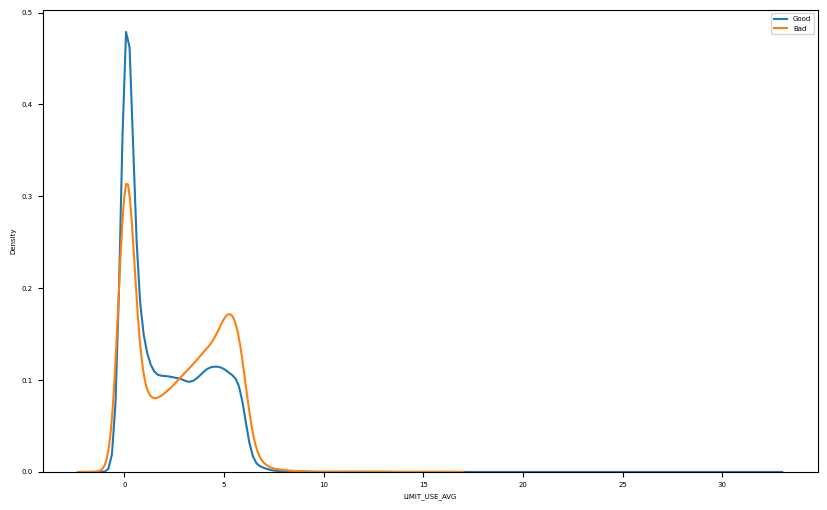

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# df에서 채무 불이행 여부가 1인 데이터만 추출하여 새로운 데이터프레임 생성
default_df = df[df['default payment next month']==1]

# LIMIT_USE_AVG에 따른 채무 불이행 여부 시각화
plt.figure(figsize=(10,6))
sns.kdeplot(df[df['default payment next month']==0]['LIMIT_USE_AVG'], label='Good')
sns.kdeplot(default_df['LIMIT_USE_AVG'], label='Bad')
plt.xlabel('LIMIT_USE_AVG')
plt.legend()
plt.show()

In [25]:
# 각 feature별 상관관계 확인

corr = df.corr()
corr

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,LIMIT_USE_AVG,delay/Limit_bal,delay,bill_change_mean
ID,1.000000,0.026179,0.018497,0.039177,-0.029079,0.018678,-0.030575,-0.011215,-0.018494,-0.002735,...,0.008406,0.039151,0.007793,0.000652,0.003000,-0.013952,0.010291,0.000369,-0.020632,-0.006540
LIMIT_BAL,0.026179,1.000000,0.024755,-0.219161,-0.108139,0.144713,-0.271214,-0.296382,-0.286123,-0.267460,...,0.178408,0.210167,0.203242,0.217202,0.219595,-0.153520,-0.383366,-0.159594,-0.316961,-0.020003
SEX,0.018497,0.024755,1.000000,0.014232,-0.031389,-0.090874,-0.057643,-0.070771,-0.066096,-0.060173,...,-0.001391,-0.008597,-0.002229,-0.001667,-0.002766,-0.039961,-0.068845,-0.049947,-0.069908,-0.001984
EDUCATION,0.039177,-0.219161,0.014232,1.000000,-0.143464,0.175061,0.105364,0.121566,0.114025,0.108793,...,-0.030038,-0.039943,-0.038218,-0.040358,-0.037200,0.028006,0.170135,0.061804,0.124347,0.002748
MARRIAGE,-0.029079,-0.108139,-0.031389,-0.143464,1.000000,-0.414170,0.019917,0.024199,0.032688,0.033122,...,-0.008093,-0.003541,-0.012659,-0.001205,-0.006641,-0.024339,0.052172,0.011723,0.035477,0.012850
AGE,0.018678,0.144713,-0.090874,0.175061,-0.414170,1.000000,-0.039447,-0.050148,-0.053048,-0.049722,...,0.021785,0.029247,0.021379,0.022850,0.019478,0.013890,-0.041719,-0.014963,-0.058217,-0.008910
PAY_0,-0.030575,-0.271214,-0.057643,0.105364,0.019917,-0.039447,1.000000,0.672164,0.574245,0.538841,...,-0.070101,-0.070561,-0.064005,-0.058190,-0.058673,0.324794,0.413453,0.455266,0.741345,0.011207
PAY_2,-0.011215,-0.296382,-0.070771,0.121566,0.024199,-0.050148,0.672164,1.000000,0.766552,0.662067,...,-0.058990,-0.055901,-0.046858,-0.037093,-0.036500,0.263551,0.496806,0.531841,0.850428,0.021071
PAY_3,-0.018494,-0.286123,-0.066096,0.114025,0.032688,-0.053048,0.574245,0.766552,1.000000,0.777359,...,-0.066793,-0.053311,-0.046067,-0.035863,-0.035861,0.235253,0.486335,0.566992,0.878080,0.016685
PAY_4,-0.002735,-0.267460,-0.060173,0.108793,0.033122,-0.049722,0.538841,0.662067,0.777359,1.000000,...,-0.001944,-0.069235,-0.043461,-0.033590,-0.026565,0.216614,0.486561,0.600924,0.890987,0.023633


<AxesSubplot: >

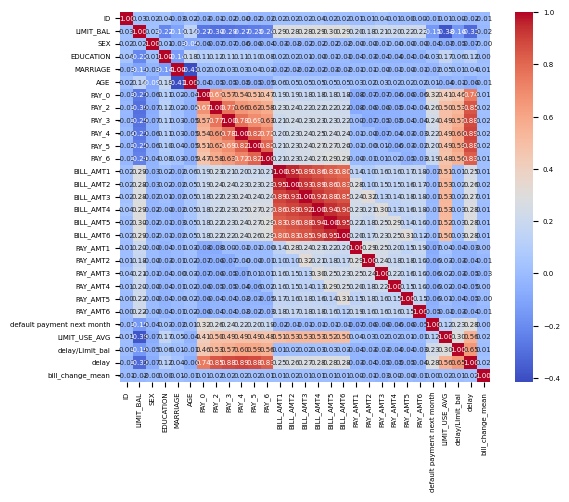

In [37]:
# 상관관계 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', size=5)

sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f', square=True)

In [38]:
df.corr().style.background_gradient(cmap='coolwarm')

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,LIMIT_USE_AVG,delay/Limit_bal,delay,LIMIT_BAL_GP,EDUCATION_re,bill_change_mean
ID,1.000000,0.026179,0.018497,0.039177,-0.029079,0.018678,-0.030575,-0.011215,-0.018494,-0.002735,-0.022199,-0.020270,0.019389,0.017982,0.024354,0.040351,0.016705,0.016730,0.009742,0.008406,0.039151,0.007793,0.000652,0.003000,-0.013952,0.010291,0.000369,-0.020632,0.025599,0.037659,-0.006540
LIMIT_BAL,0.026179,1.000000,0.024755,-0.219161,-0.108139,0.144713,-0.271214,-0.296382,-0.286123,-0.267460,-0.249411,-0.235195,0.285430,0.278314,0.283236,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595,-0.153520,-0.383366,-0.159594,-0.316961,0.926715,-0.231088,-0.020003
SEX,0.018497,0.024755,1.000000,0.014232,-0.031389,-0.090874,-0.057643,-0.070771,-0.066096,-0.060173,-0.055064,-0.044008,-0.033642,-0.031183,-0.024563,-0.021880,-0.017005,-0.016733,-0.000242,-0.001391,-0.008597,-0.002229,-0.001667,-0.002766,-0.039961,-0.068845,-0.049947,-0.069908,0.026129,0.013627,-0.001984
EDUCATION,0.039177,-0.219161,0.014232,1.000000,-0.143464,0.175061,0.105364,0.121566,0.114025,0.108793,0.097520,0.082316,0.023581,0.018749,0.013002,-0.000451,-0.007567,-0.009099,-0.037456,-0.030038,-0.039943,-0.038218,-0.040358,-0.037200,0.028006,0.170135,0.061804,0.124347,-0.213007,0.981832,0.002748
MARRIAGE,-0.029079,-0.108139,-0.031389,-0.143464,1.000000,-0.414170,0.019917,0.024199,0.032688,0.033122,0.035629,0.034345,-0.023472,-0.021602,-0.024909,-0.023344,-0.025393,-0.021207,-0.005979,-0.008093,-0.003541,-0.012659,-0.001205,-0.006641,-0.024339,0.052172,0.011723,0.035477,-0.095609,-0.149134,0.012850
AGE,0.018678,0.144713,-0.090874,0.175061,-0.414170,1.000000,-0.039447,-0.050148,-0.053048,-0.049722,-0.053826,-0.048773,0.056239,0.054283,0.053710,0.051353,0.049345,0.047613,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478,0.013890,-0.041719,-0.014963,-0.058217,0.126906,0.182434,-0.008910
PAY_0,-0.030575,-0.271214,-0.057643,0.105364,0.019917,-0.039447,1.000000,0.672164,0.574245,0.538841,0.509426,0.474553,0.187068,0.189859,0.179785,0.179125,0.180635,0.176980,-0.079269,-0.070101,-0.070561,-0.064005,-0.058190,-0.058673,0.324794,0.413453,0.455266,0.741345,-0.267852,0.112593,0.011207
PAY_2,-0.011215,-0.296382,-0.070771,0.121566,0.024199,-0.050148,0.672164,1.000000,0.766552,0.662067,0.622780,0.575501,0.234887,0.235257,0.224146,0.222237,0.221348,0.219403,-0.080701,-0.058990,-0.055901,-0.046858,-0.037093,-0.036500,0.263551,0.496806,0.531841,0.850428,-0.293010,0.129703,0.021071
PAY_3,-0.018494,-0.286123,-0.066096,0.114025,0.032688,-0.053048,0.574245,0.766552,1.000000,0.777359,0.686775,0.632684,0.208473,0.237295,0.227494,0.227202,0.225145,0.222327,0.001295,-0.066793,-0.053311,-0.046067,-0.035863,-0.035861,0.235253,0.486335,0.566992,0.878080,-0.281252,0.122425,0.016685
PAY_4,-0.002735,-0.267460,-0.060173,0.108793,0.033122,-0.049722,0.538841,0.662067,0.777359,1.000000,0.819835,0.716449,0.202812,0.225816,0.244983,0.245917,0.242902,0.239154,-0.009362,-0.001944,-0.069235,-0.043461,-0.033590,-0.026565,0.216614,0.486561,0.600924,0.890987,-0.266039,0.116531,0.023633


In [54]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,LIMIT_USE_AVG,delay/Limit_bal,delay
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200,2.238288,0.019322,-0.182439
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062,2.111340,0.244398,0.982176
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000,-1.395540,-2.000000,-2.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000,0.179982,-0.041667,-0.833333
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000,1.709004,0.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000,4.127575,0.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000,32.185850,5.333333,6.000000


In [6]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [50, 100, 200, 500, 1000],
          'learning_rate' : [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],
          'max_depth': [5, 7, 9, 11, 13, 15]
         }

# LGBMClassifier 객체 생성 후 GridSearchCV 수행
lgbm_clf = LGBMClassifier(random_state=123456)
grid_cv = GridSearchCV(lgbm_clf, param_grid=params, cv=3, n_jobs=-1, scoring='precision')
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
최고 예측 정확도: 0.7302


In [8]:
from sklearn.metrics import classification_report

# 모델 예측
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)

# 예측 결과 출력 (정밀도, 재현율, F1-score)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.73      0.25      0.38      1327

    accuracy                           0.81      6000
   macro avg       0.77      0.61      0.63      6000
weighted avg       0.80      0.81      0.78      6000

